In [1]:
import os 
import re 
import ast
import random 
from abc import ABC, abstractmethod
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

MAIN_PATH = os.path.join("/Users", "jcheigh", "Thesis")
DATA_PATH = os.path.join(MAIN_PATH, "data")
PLOT_PATH = os.path.join(MAIN_PATH, "plots")
RES_PATH  = os.path.join(MAIN_PATH, "results")

PLOT_PATHS = {
    "error plots"     : f"{PLOT_PATH}/error plots/",
    "char plots"      : f"{PLOT_PATH}/char sum plots/",   
    "fourier plots"   : f"{PLOT_PATH}/fourier plots/",   
    }

PLOT_NAME  = {
    "error plots"     : r"p = (?P<prime>\d+) error plot.jpg",
    "char plots"      : r"p = (?P<prime>\d+) char sum plot.jpg",
    "fourier plots"   : r"p = (?P<prime>\d+) fourier exp plot.jpg"
    }

PLOT_PARAMS = {
    "error plots"     : ("prime"),
    "char plots"      : ("prime"),
    "fourier plots"   : ("prime"),
    }

CSV_PATHS = {
    "raw error"       : f"{DATA_PATH}/raw_error.csv",
    "processed_error" : f"{DATA_PATH}/processed_error.csv"
    }

EXP_PATHS = {
    "character sum"   : f"{DATA_PATH}/char sum lists/",
    "polya fourier"   : f"{DATA_PATH}/polya fourier lists/",
    "symmetry"        : f"{DATA_PATH}/symmetry/",
    "leg fixed n"     : f"{DATA_PATH}/legendre fixed n/",
    "error lists"     : f"{DATA_PATH}/error lists/",
    'antisymmetry'    : f"{DATA_PATH}/antisymmetry/"
    }  

EXP_NAME = {
    "symmetry"        : r"symmetry\(p=(?P<prime>\d+),d=(?P<delta>\d+)\)",
    "polya fourier"   : r"p = (?P<prime>\d+) fourier exp list",
    "character sum"   : r"p = (?P<prime>\d+) character sum list",
    "leg fixed n"     : r"n = (?P<n>\d+) legendre symbol list",
    "error lists"     : r"p = (?P<prime>\d+) error list",
    'antisymmetry'    : r"antisymmetry\(p=(?P<prime>\d+),d=(?P<delta>\d+)\)",
    } 

EXP_PARAMS = {
    "symmetry"        : ('prime', 'delta'),
    "polya fourier"   : ("prime"),
    "character sum"   : ("prime"),
    "leg fixed n"     : ('n'),
    "error lists"     : ("prime"),
    "antisymmetry"    : ('prime', 'delta')
    }   

def process(lst):
    processed_lst = []  

    for item in lst:
        # If the item starts with a '(', consider it a tuple
        if item.startswith('('):
            try:
                # Safely evaluate the item as a tuple
                processed_tuple = ast.literal_eval(item)
                processed_lst.append(processed_tuple)
            except ValueError:
                # If there's an error, just append the original string
                processed_lst.append(item)
        else:
            try:
                # Convert the item to a float
                processed_lst.append(float(item))
            except ValueError:
                # If there's an error, just append the original string
                processed_lst.append(item)

    return processed_lst

def fetch_data(experiment):
    ### Usage: fetch_data('polya fourier')
    path   = EXP_PATHS[experiment]  # f"{DATA_PATH}/symmetry/",
    name   = EXP_NAME[experiment]   # symmetry\(p=(?P<prime>\d+),d=(?P<delta>\d+)\)",
    params = EXP_PARAMS[experiment] # (prime, delta)
    
    data = {}
    for filename in os.listdir(path):
        # Match the filename with the regex pattern
        match = re.search(name, filename)
        if match:
            if isinstance(params, str):
                key = int(match.group(params))
            elif isinstance(params, tuple):
                key = tuple([int(match.group(param)) for param in params]) # (17, 3)
            else:
                raise Exception(f"Invalid Params Type: {params}")

            # Read the file and get the list of elements
            with open(os.path.join(path, filename), 'r') as file:
                elements = [line.strip() for line in file.readlines()]

            elements = process(elements)
            # Update the global dictionary
            data[key] = elements

    return data 

def read_csv(name):
    ### Usage: read_csv('processed_error')
    return pd.read_csv(CSV_PATHS[name])

def get_plot_dict(name):
    ### returns {105601 : "/Users/jcheigh/Thesis/..."}
    path   = PLOT_PATHS[name]
    params = PLOT_PARAMS[name]
    name   = PLOT_NAME[name]

    result = {}
    for filename in os.listdir(path):
        match = re.search(name, filename)
        if match:
            if isinstance(params, str):
                key = int(match.group(params))
            elif isinstance(params, tuple):
                key = tuple([int(match.group(param)) for param in params]) # (17, 3)
            else:
                raise Exception(f"Invalid Params Type: {params}")

            result[key] = os.path.join(path, filename)
    
    return result

def plot(name, params=None, N=1):
    path_map = get_plot_dict(name)
    
    if params:
        # use params
        paths = [path_map[param] for param in params]

    else:
        # or random N
        paths = random.choices(list(path_map.values()), k=N)

    for path in paths:
        try:
            img = Image.open(path)
            plt.figure(figsize = (20,10))
            plt.imshow(img)
            plt.axis('off')  # Turn off axis
            plt.show()
        except Exception:
            print(f"Plot failed")

class Saver(ABC):
    
    @property
    @abstractmethod
    def path(self):
        """Abstract property for the path where files should be saved."""
        raise NotImplementedError

    @property
    @abstractmethod 
    def type(self):
        """Abstract property for data type: one of (plot, df, list)"""
        raise NotImplementedError

    @abstractmethod
    def get_name(self, params):
        """Abstract method to generate the filename based on the parameters."""
        raise NotImplementedError
    
    def __init__(self):
        # Check if path exists, and create it if it doesn't
        if not os.path.exists(self.path):
            os.makedirs(self.path)
    
    def _get_full_path(self, name, extension):
        """Construct the full path."""
        return os.path.join(self.path, f"{name}.{extension}")

    def _check_overwrite(self, path):
        """Check if file exists and handle overwriting."""
        if os.path.exists(path):
            print(f"Overwriting {path}")
            with open(path, 'r') as f:
                original_data = f.read()
            return original_data
        return None

    def _save_data(self, params, data):
        """Save data to the specified path."""
        name = self.get_name(params)
        
        if self.type == "df":
            # Save DataFrame to .csv
            path = self._get_full_path(name, "csv")
            data.to_csv(path, index=False)
            return None

        elif self.type == "list":
            # Save list to .txt
            path = self._get_full_path(name, "txt")
            original_data = self._check_overwrite(path)
            with open(path, 'w') as f:
                for item in data:
                    f.write(f"{item}\n")
            return original_data

        elif self.type == 'plot':
            # Save plt object to .png
            path = self._get_full_path(name, "jpg")
            data.savefig(path)
            return None

        else:
            raise TypeError("Unsupported data type for saving.")

    def save(self, params, data):
        return self._save_data(params, data)

def histplot(x, bins=30, xlabel=None, title=None):
    # distribution of numerical
    plt.figure(figsize = (10,8))
    p = sns.histplot(x, bins=bins, kde=True, fill=True,
                    edgecolor="black", linewidth=3
                    )

    p.axes.lines[0].set_color("orange")
    
    if xlabel is None:
        xlabel = str(x)
        
    if title is None:
        title = f"{xlabel} Distribution"
    
    plt.ylabel("Count", fontsize = 20)
    plt.xlabel(xlabel, fontsize = 20)
    plt.title(title, fontsize = 25)
    plt.show()
    return p

def countplot(x, xlabel, title = None, savefig = False, savename = None):
    # distribution of categorical
    plt.figure(figsize = (10,8))
    p = sns.countplot(x = x, order = sorted(set(x)))
    
    for container in p.containers: 
        p.bar_label(container, label_type = "center", padding = 6, size = 15, color = "black", 
                    bbox={"boxstyle": "round", "pad": 0.4,"facecolor": "#e0b583", 
                          "edgecolor": "#1c1c1c", "linewidth" : 4, "alpha": 1})
        
    if title is None:
        title = f"Breakdown of {xlabel}"
    
    p.axes.set_title(title, fontsize = 25)
    p.axes.set_ylabel("Count",fontsize = 20)
    p.axes.set_xlabel(xlabel, fontsize = 20) 
    plt.show()  
    return p 

def violinplot(x, y, xlabel, ylabel, title = None): 
    # x is categorical, y is numerical 
    plt.figure(figsize = (10, 8))
        
    p = sns.violinplot(x = x, y = y, order = sorted(set(x)),
                       linewidth = 3, edgecolor = "black")

    if title is None:
        title = f"{ylabel} by {xlabel}"
    
    p.axes.set_title(title, fontsize = 25)
    p.axes.set_xlabel(xlabel, fontsize = 20)
    p.axes.set_ylabel(ylabel, fontsize = 20)
    plt.show()
    return p

def kdeplot(x, y, xlabel, ylabel, title=None):
    # both numeric
    plt.figure(figsize=(10, 8))
    
    p = sns.kdeplot(x=x, y=y, fill=True)
    
    if title is None:
        title = f"{ylabel} by {xlabel}"
        
    p.axes.set_title(title, fontsize=25)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.show()
    return p

def scatter(x, y, xlabel, ylabel, title=None):
    # both numeric
    plt.figure(figsize=(10, 8))
    sns.set(style='ticks')
    sns.set_context("poster")

    if title is None:
        title = f"{ylabel} by {xlabel}"
    
    p = sns.regplot(x=x, y=y)
        
    p.axes.set_title(title, fontsize=25)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.show()
    return p

def char_sum_plot(prime):
    prime = 5
    char_sum_data = {prime : [1,2,3,4,5]}
    fig, ax = plt.subplots(figsize=(20,10))
    x = list(range(0, prime))
    y = char_sum_data[prime]
    ax.plot(x, y, label=f"S_p(x) for p = {prime}")

    mean, sd = np.mean(y), np.std(y)
    largest, smallest = max(y), min(y)
    
    ax.axhline(y=mean, color='b', linestyle='--', label=f"Mean(S_p(x) = {round(mean, 3)}")
    ax.axhline(y=mean + sd, color='r', linestyle='--', label=f"+1 SD = {round(mean,3)} + {round(sd, 3)}")
    ax.axhline(y=mean - sd, color='r', linestyle='--', label=f"-1 SD = {round(mean,3)} - {round(sd, 3)}")
    ax.axhline(y=largest, color='b', linestyle='--', label=f"Max(S_p(x)) = {round(largest, 3)}")
    ax.axhline(y=smallest, color='b', linestyle='--', label=f"Min(S_p(x)) = {round(smallest,3)}")
  
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("x")
    ax.set_ylabel('char sum')
    ax.set_title(f"Char Sum for p = {prime} (p = {prime % 4} mod 4)")
    return fig
    
"""Example Usage of Saver"""

class ErrorPlotSaver(Saver):
    path = PLOT_PATH
    type = 'plot'

    def get_name(self, params):
        if isinstance(params, tuple):
            prime = params[0]
        elif isinstance(params, int):
            prime = params
        else:
            raise TypeError("params should be a tuple or an integer")

        return f"p = {prime} error plot"

### USAGE:
### saver = ErrorPlotSaver()
### plot = error_plot(p)
### saver.save(plot, p)

In [2]:
class ErrorListSaver(Saver):
    path = f'{DATA_PATH}/error lists/'
    type = 'list'

    def get_name(self, params):
        if isinstance(params, tuple):
            prime = params[0]
        elif isinstance(params, int):
            prime = params
        else:
            raise TypeError("params should be a tuple or an integer")

        return f"p = {prime} error list"


In [3]:
### fetch data
fourier_data  = fetch_data("polya fourier")
char_sum_data = fetch_data("character sum")

In [4]:
def update_error_lst():
    overlap = list(set(fourier_data.keys()).intersection(set(char_sum_data.keys())))
    saver   = ErrorListSaver()

    for prime in overlap:
        fourier   = np.array(fourier_data[prime])
        char_sum  = np.array(char_sum_data[prime])
        error_lst = char_sum - fourier
        saver.save(prime, error_lst)

In [5]:
error_data = fetch_data("error lists")

In [6]:
def partition_mod4():
    one = [prime for prime in error_data.keys() if prime % 4 == 1]
    three = [prime for prime in error_data.keys() if prime % 4 == 3]
    return {1: one, 3 : three}

def get_means():
    partition = partition_mod4()
    results = {}
    for prime in partition[1]:
        data = error_data[prime]
        print('=' * 20)
        mean = np.mean(data)
        std_dev = np.std(data)
        results[prime] = (1, mean, std_dev)
        print(f"Prime = {prime}, 1 mod 4, mean = {mean}, std dev = {std_dev}")

    for prime in partition[3]:
        data = error_data[prime]
        print('=' * 20)
        mean = np.mean(data)
        std_dev = np.std(data)
        results[prime] = (3, mean, std_dev)
        print(f"Prime = {prime}, 3 mod 4, mean = {mean}, std dev = {std_dev}")

    return results

results = get_means()

Prime = 141269, 1 mod 4, mean = 1.6095086356046412e-18, std dev = 7.137085374598465
Prime = 113149, 1 mod 4, mean = -6.731847499622863e-17, std dev = 6.504170150559251
Prime = 122021, 1 mod 4, mean = -5.590193707064326e-18, std dev = 6.705048406836319
Prime = 117709, 1 mod 4, mean = -5.7949776680601835e-18, std dev = 6.609606331706121
Prime = 125693, 1 mod 4, mean = -1.3069739803150148e-16, std dev = 6.805187094673613
Prime = 129749, 1 mod 4, mean = -1.577170597838202e-17, std dev = 6.889123804578599
Prime = 195457, 1 mod 4, mean = -1.3494193787592627e-16, std dev = 8.165777026654704
Prime = 117673, 1 mod 4, mean = -3.0916002881644155e-17, std dev = 6.608585485649126
Prime = 192529, 1 mod 4, mean = -5.904920179381601e-17, std dev = 8.104383904250582
Prime = 196993, 1 mod 4, mean = 6.290510480908533e-17, std dev = 8.197799400419314
Prime = 1020389, 1 mod 4, mean = 6.996874142035524e-17, std dev = 16.429832141712446
Prime = 108529, 1 mod 4, mean = 2.514059933583452e-17, std dev = 6.39363

All 1 mod 4 have mean 0 (~10e-17+=1), whereas all 3 mod 4 have mean nonzero. Further, the very large primes (~1 million) are indistinguishable.

However, standard deviation seems to grow in a pretty predictable way with size of prime (~6-8 for 100000-200000 and ~16.3-16.4 for 1 million).

In [7]:
error_means = []
fourier_means = []
char_means = []

for prime in results:
    try:
        error_lst    = error_data[prime]
        print(f'======{prime % 4} mod 4=====')
        print(f'full: {np.mean(error_lst)}')
        print(f"half: {np.mean(error_lst[:prime // 2])}")
    
        fourier_lst  = fourier_data[prime]
        char_sum_lst = char_sum_data[prime]

        error_means.append(abs(np.mean(error_lst)))
        fourier_means.append(abs(np.mean(fourier_lst)))
        char_means.append(abs(np.mean(char_sum_lst)))
    except:
        pass


======1 mod 4=====
full: 1.6095086356046412e-18
half: 0.03005652157849086
======1 mod 4=====
full: -6.731847499622863e-17
half: 0.024146278400002295
======1 mod 4=====
full: -5.590193707064326e-18
half: -0.014143815259950294
======1 mod 4=====
full: -5.7949776680601835e-18
half: 0.0390515512964284
======1 mod 4=====
full: -1.3069739803150148e-16
half: 0.0028174353865740042
======1 mod 4=====
full: -1.577170597838202e-17
half: 0.029482689521225725
======1 mod 4=====
full: -1.3494193787592627e-16
half: 0.009638917841278884
======1 mod 4=====
full: -3.0916002881644155e-17
half: 0.014341559589367016
======1 mod 4=====
full: -5.904920179381601e-17
half: 0.018786177816633217
======1 mod 4=====
full: 6.290510480908533e-17
half: -0.0026849543919789534
======1 mod 4=====
full: 6.996874142035524e-17
half: 0.007414787316197435
======1 mod 4=====
full: 2.514059933583452e-17
half: 0.0021168483684045
======1 mod 4=====
full: -3.0527298011476863e-17
half: -0.034578443296042094
======1 mod 4=====
full

Mean of 1st half of error list is still basically 0, though not as small as before.

Text(0.5, 1.0, 'Error^2 for p = 196993 (p = 1 mod 4)')

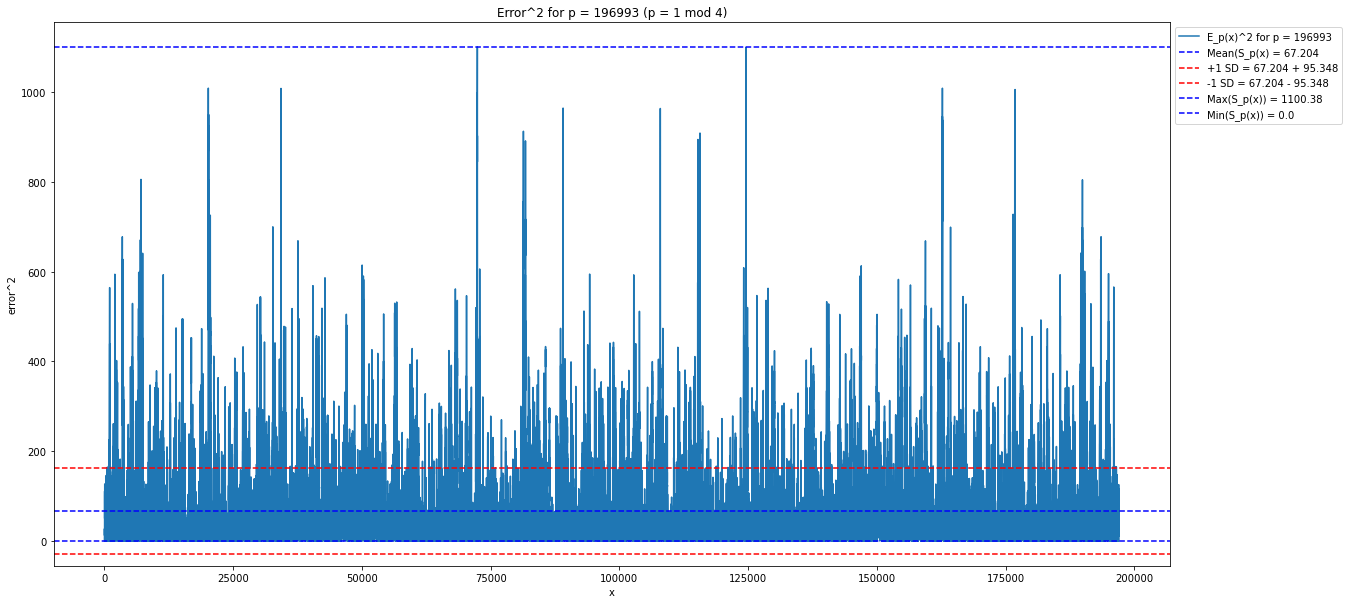

In [8]:
prime = 196993
fig, ax = plt.subplots(figsize=(20,10))
x = list(range(0, prime))
y = [x**2 for x in error_data[prime]]
ax.plot(x, y, label=f"E_p(x)^2 for p = {prime}")

mean, sd = np.mean(y), np.std(y)
largest, smallest = max(y), min(y)

ax.axhline(y=mean, color='b', linestyle='--', label=f"Mean(S_p(x) = {round(mean, 3)}")
ax.axhline(y=mean + sd, color='r', linestyle='--', label=f"+1 SD = {round(mean,3)} + {round(sd, 3)}")
ax.axhline(y=mean - sd, color='r', linestyle='--', label=f"-1 SD = {round(mean,3)} - {round(sd, 3)}")
ax.axhline(y=largest, color='b', linestyle='--', label=f"Max(S_p(x)) = {round(largest, 3)}")
ax.axhline(y=smallest, color='b', linestyle='--', label=f"Min(S_p(x)) = {round(smallest,3)}")

ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel("x")
ax.set_ylabel('error^2')
ax.set_title(f"Error^2 for p = {prime} (p = {prime % 4} mod 4)")


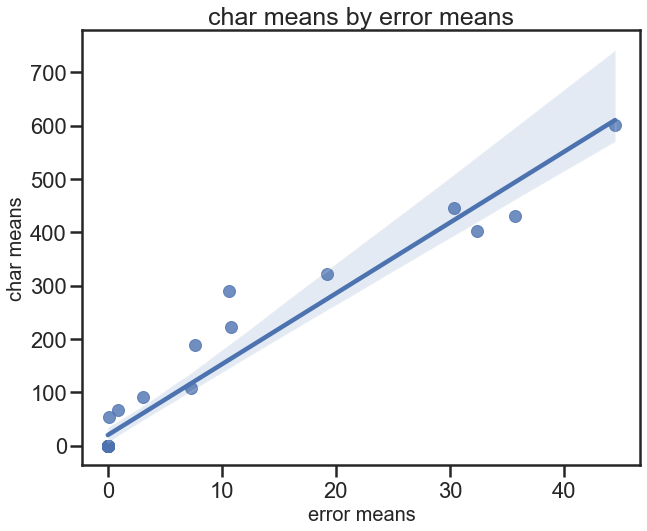

<AxesSubplot:title={'center':'char means by error means'}, xlabel='error means', ylabel='char means'>

In [9]:
scatter(error_means, char_means, 'error means', 'char means')

In [11]:
error_vals = {prime : (np.mean(lst), np.std(lst)) for prime, lst in error_data.items()}

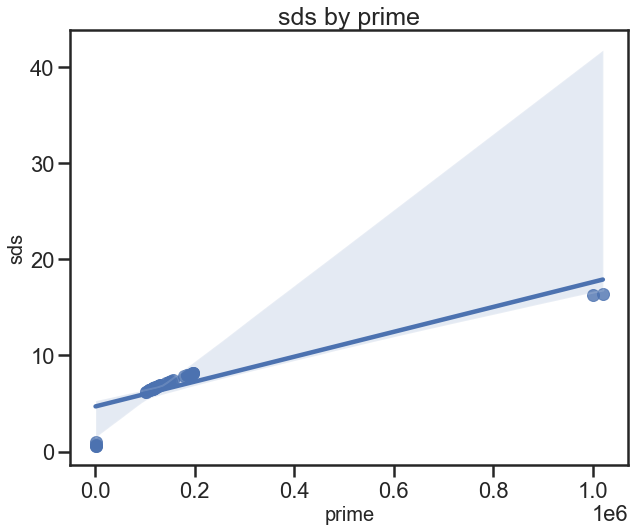

<AxesSubplot:title={'center':'sds by prime'}, xlabel='prime', ylabel='sds'>

In [20]:
means = [mean for prime, (mean, _) in error_vals.items()]
sds   = [sd for prime, (_, sd) in error_vals.items()]
primes = [prime for prime in error_vals]
scatter(primes, sds, 'prime', 'sds')

In [22]:
# Define transformations
transformations = {
    "Logarithm": np.log,
    "Square root": np.sqrt,
    "Square": lambda x: x**2,
    "Exponential": np.exp
}

sds = np.array(sds)
primes = np.array(primes)
# Compute correlations for each transformation
correlations = {}
for name, func in transformations.items():
    try:
        transformed_X = func(primes)
        correlation = np.corrcoef(transformed_X.ravel(), sds)[0, 1]
        correlations[name] = correlation
    except Exception as e:
        correlations[name] = str(e)

correlations


/var/folders/mk/xfkqlxln61zfl67lsk0rwfkr0000gn/T/ipykernel_50612/3824560581.py:15: RuntimeWarning: overflow encountered in exp
  transformed_X = func(primes)
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


{'Logarithm': 0.8454616020729427,
 'Square root': 0.9960362174493341,
 'Square': 0.7657570129794029,
 'Exponential': nan}

In [41]:
prime = 196993
error_lst = error_data[prime]


In [48]:
error = error_lst[: (prime -1 )//2 + 1]
np.var(error) - np.var(error_lst)

0.0037152540110838572

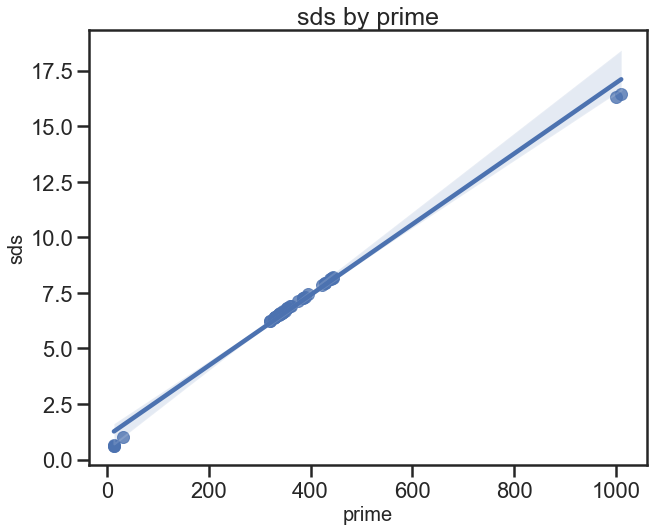

<AxesSubplot:title={'center':'sds by prime'}, xlabel='prime', ylabel='sds'>

In [23]:
scatter(np.sqrt(primes), sds, 'prime', 'sds')

Roughly
$$
\mathrm{sd} = \beta_1 \sqrt{p} + \beta_0
$$

In [51]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression().fit(primes.reshape(-1,1), np.array(vars).reshape(-1,1))

# Retrieve the coefficients
intercept = linear_reg.intercept_
slope = linear_reg.coef_[0]

intercept, slope

(array([12.57847962]), array([0.00025732]))

In [53]:
x = [1,2,3,0]
sorted(x)

[0, 1, 2, 3]

Max Mean: 78.278092759729
Min Mean: -78.39540132059888
Max 99th Percentile: 89.91106025493454
Min 99th Percentile: -70.73760109078772
Max 1st Percentile: 71.20489399907842
Min 1st Percentile: -91.70620660580366


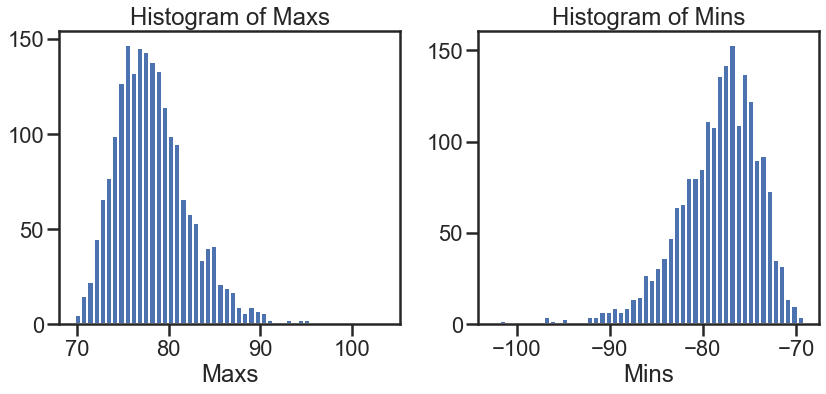

In [59]:
def min_max_dist_vectorized(n, p):
    var = 12.6 + p * 0.000257 # variance regression formula
    smpl_matrix = np.sqrt(var) * np.random.randn(n, (p-1)//2)
    
    maxs = np.max(smpl_matrix, axis=1)
    mins = np.min(smpl_matrix, axis=1)

    print(f"Max Mean: {np.mean(maxs)}")
    print(f"Min Mean: {np.mean(mins)}")
    print(f"Max 99th Percentile: {np.percentile(maxs, 99)}")
    print(f"Min 99th Percentile: {np.percentile(mins, 99)}")
    print(f"Max 1st Percentile: {np.percentile(maxs, 1)}")
    print(f"Min 1st Percentile: {np.percentile(mins, 1)}")  

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(maxs, bins=50)
    plt.title("Histogram of Maxs")
    plt.xlabel("Maxs")
    
    plt.subplot(1, 2, 2)
    plt.hist(mins, bins=50)
    plt.title("Histogram of Mins")
    plt.xlabel("Mins")
    
    plt.tight_layout()
    plt.show()

# Let's test the function
min_max_dist_vectorized(2000, 1020389)


Some numbers (all n = 2000)

for prime == 1009 we get max +=14 and min += 8, for prime == 196993 we get max += 41, min += 31, for prime == 1020389 we get max += 91 min += 71. In other words here's a really hard proof strategy:
1. Show that the errors never diverge too much from normally distributed with mean near 0 and variance roughly linear w.r.t. prime 
2. Show that normally distributed gives you this bound with high probability

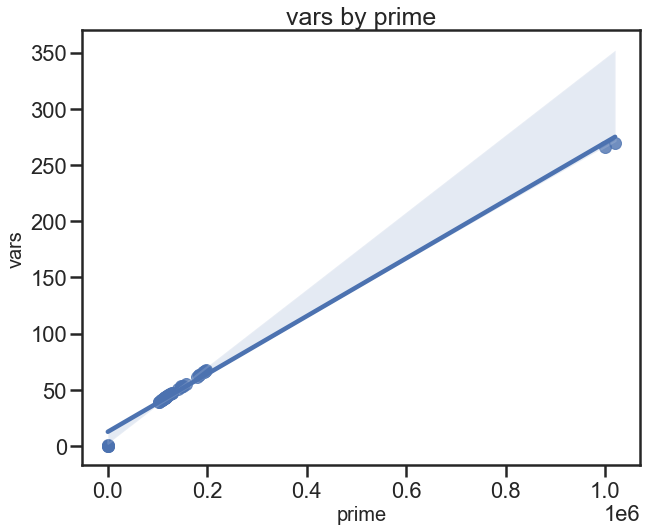

<AxesSubplot:title={'center':'vars by prime'}, xlabel='prime', ylabel='vars'>

In [26]:
vars = [sd ** 2 for sd in sds]
scatter(primes, vars, 'prime', 'vars')

Variance is roughly linear with respect to the prime. Let's try to get a gauge on what this means. Let's treat the error as a r.v. right now:


Let $X \sim \mathrm{Unif}\{0, p-1\}$ be a discrete uniform random variable, conditioned on an implied prime $p \equiv 1\  \mathrm{mod}\   4$. Then the error random variable is $E_p(X)$. For the sake of simplicity, we will assume $E_p(X)$ is normal. Since $p \equiv 1\ \mathrm{mod}\ 4$, we'll assume $\mathbb{E}(E_p(X)) = 0$. Finally, we'll assume $\mathrm{Var}(E_p(X)) = \beta_1 \cdot p + \beta_0$, where $\beta_1, \beta_0 \in \mathbb{R}$ are constant parameters. Technically we should have some error term $\epsilon$ that's a Gaussian centered at 0, but whatever. Overall, we get that 
$$
E_p(X) \sim \mathcal{N}(0, \beta_1 \cdot p + \beta_0).
$$

### In Depth Analysis: <br>
- p = 196993 (1 mod 4)

In [8]:
error_data.keys()

dict_keys([141269, 115151, 113149, 122021, 117709, 125693, 129749, 195457, 117673, 192529, 125791, 196993, 102359, 1020389, 108529, 108791, 178757, 130099, 183119, 150929, 997, 183167, 119087, 1000003, 196519, 147859, 108013, 116257, 197, 108727, 115561, 193013, 114599, 199, 113749, 193, 156601, 147629, 102139, 114847, 120011])

In [9]:
prime        = 196993
error_lst    = error_data[prime]
fourier_lst  = fourier_data[prime]
char_sum_lst = char_sum_data[prime]

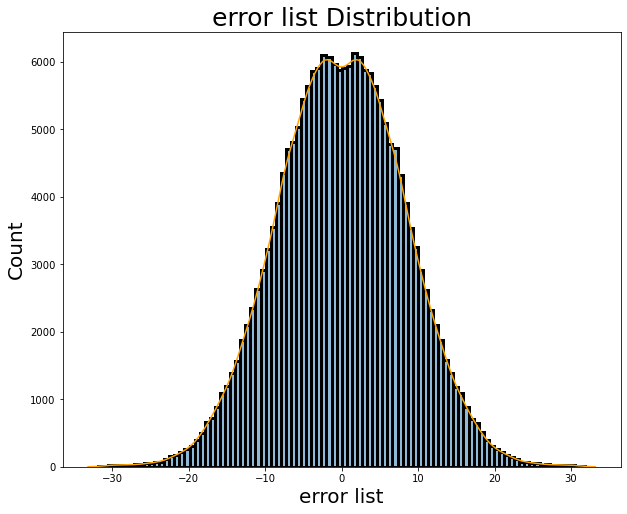

<AxesSubplot:title={'center':'error list Distribution'}, xlabel='error list', ylabel='Count'>

In [10]:
histplot(error_lst, bins=100, xlabel='error list')

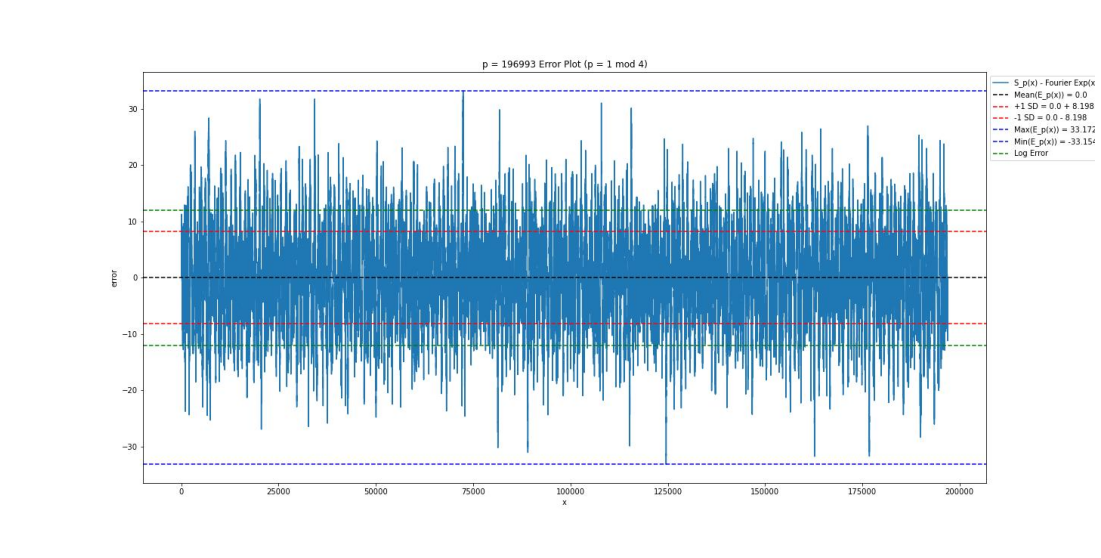

In [11]:
plot('error plots', [(196993)])

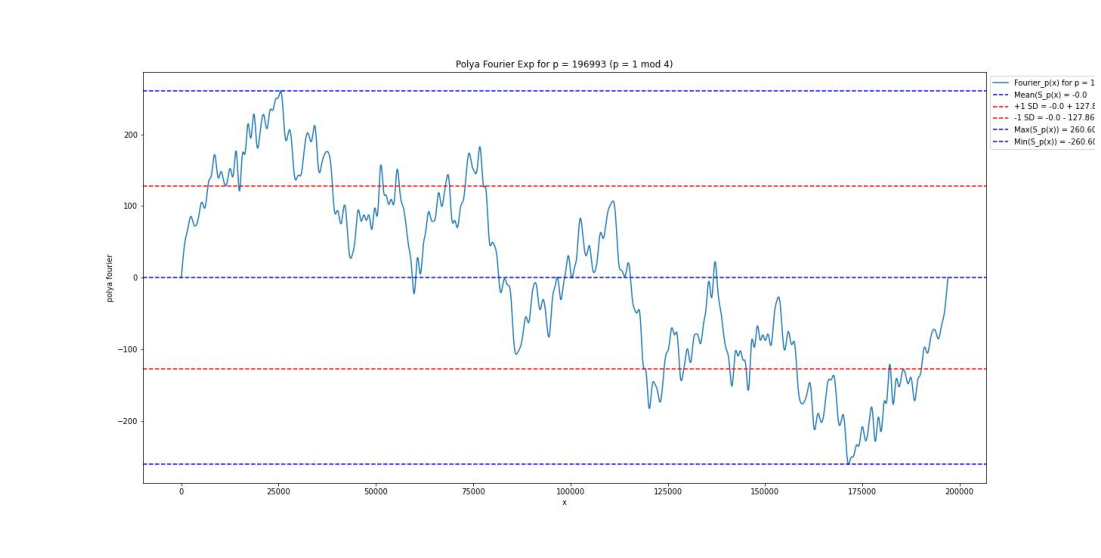

In [12]:
plot('fourier plots', [(196993)])

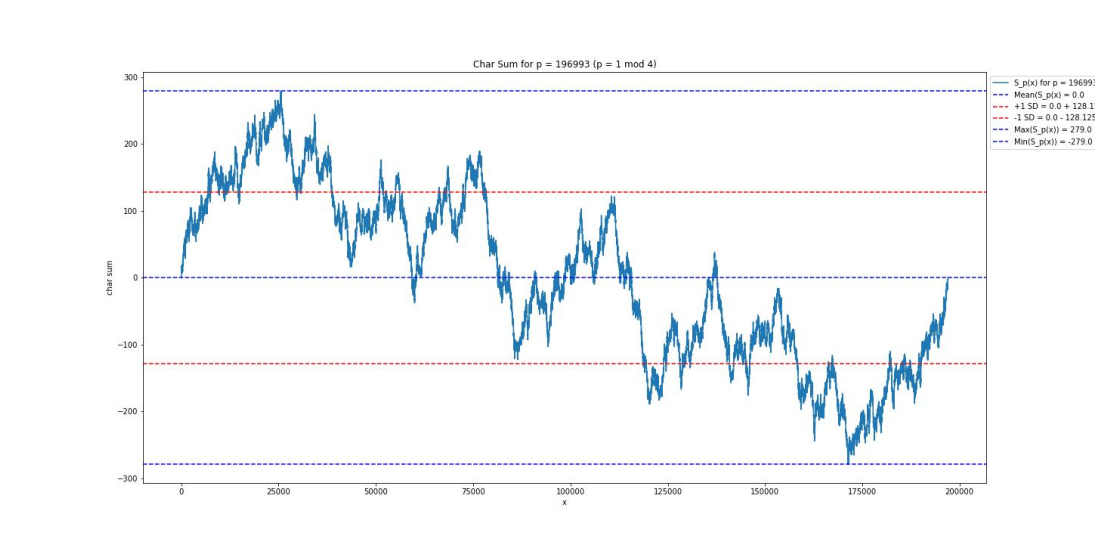

In [13]:
plot('char plots', [(196993)])

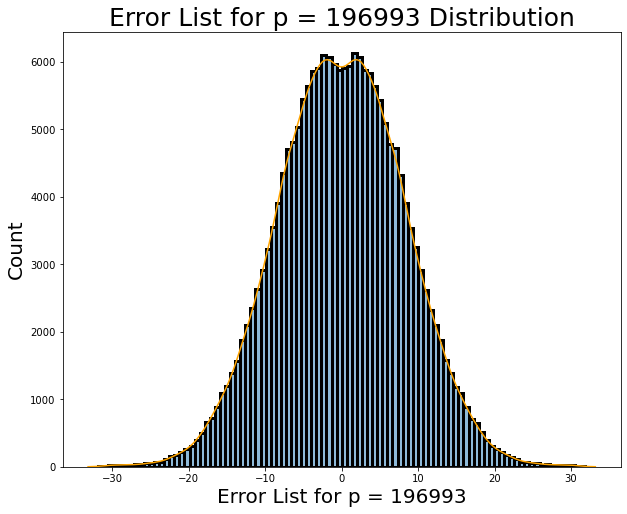

<AxesSubplot:title={'center':'Error List for p = 196993 Distribution'}, xlabel='Error List for p = 196993', ylabel='Count'>

In [14]:
histplot(error_lst, bins= 100, xlabel = f"Error List for p = {prime}")

Seems normal like. An ambitious yet realistic conjecture would be that the distribution of the error list converges to a Gaussian. In the case where p is 1 mod 4, this Gaussian has mean 0 and standard deviation a monotonic function of p. I think the standard deviation should be something like a linear function of sqrt(p), though this isn't exactly right.

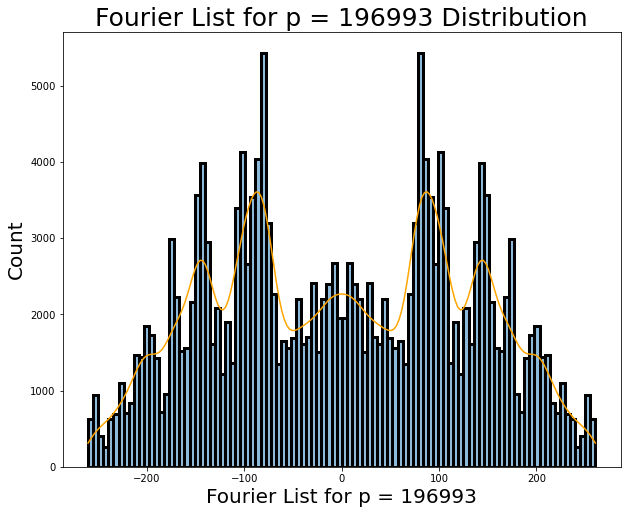

<AxesSubplot:title={'center':'Fourier List for p = 196993 Distribution'}, xlabel='Fourier List for p = 196993', ylabel='Count'>

In [15]:
histplot(fourier_lst, bins= 100, xlabel = f"Fourier List for p = {prime}")

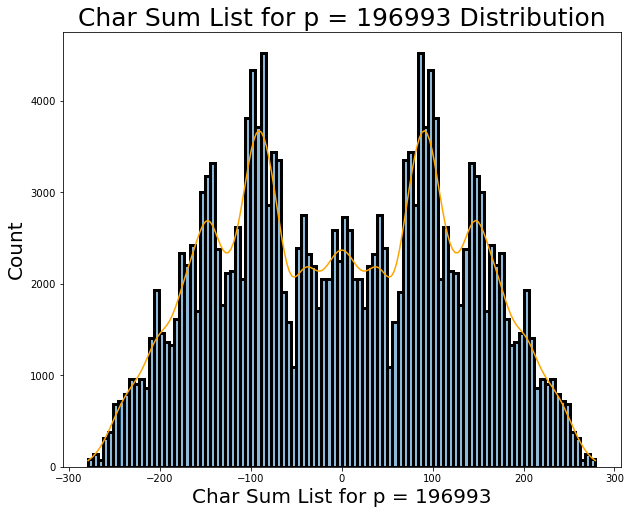

<AxesSubplot:title={'center':'Char Sum List for p = 196993 Distribution'}, xlabel='Char Sum List for p = 196993', ylabel='Count'>

In [16]:
histplot(char_sum_lst, bins= 100, xlabel = f"Char Sum List for p = {prime}")

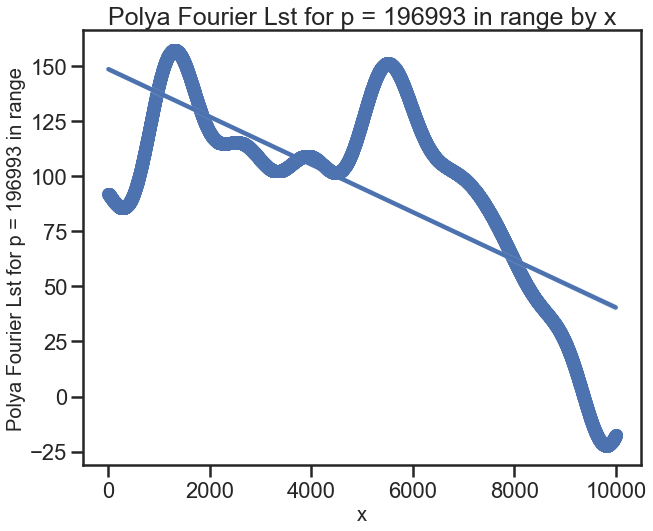

<AxesSubplot:title={'center':'Polya Fourier Lst for p = 196993 in range by x'}, xlabel='x', ylabel='Polya Fourier Lst for p = 196993 in range'>

In [17]:
scatter(list(range(10000)), fourier_lst[50000:60000], "x", f"Polya Fourier Lst for p = 196993 in range")

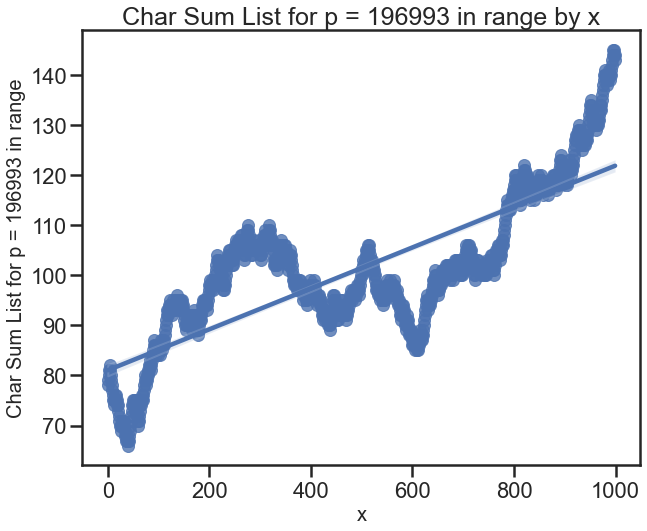

<AxesSubplot:title={'center':'Char Sum List for p = 196993 in range by x'}, xlabel='x', ylabel='Char Sum List for p = 196993 in range'>

In [18]:
scatter(list(range(1000)), char_sum_lst[50000:51000], "x", f"Char Sum List for p = 196993 in range")

Character sum is seemingly random.

### Is Character Sum Brownian Motion?

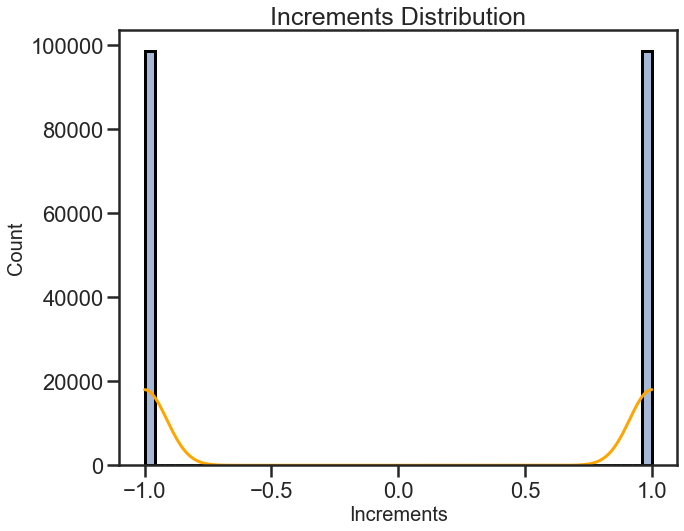

Mean of Increments: 0.0
Standard Deviation of Increments: 1.0


In [19]:
increments = [char_sum_lst[i+1] - char_sum_lst[i] for i in range(196993-1)]
mean_increment = sum(increments) / len(increments)
std_increment = (sum([(incr - mean_increment)**2 for incr in increments]) / len(increments))**0.5

histplot(increments, bins=50, xlabel="Increments")
print(f"Mean of Increments: {mean_increment}")
print(f"Standard Deviation of Increments: {std_increment}")

The argument here would be by Donsker's Invariance Principle. Basically a simple random walk (+/- 1 with equal probability and all independent) converges to brownian motion in the limit (small step and back length). The problem is that each step must be independent and they're not (legendre is multiplicative). Maybe something with only looking at primes but not sure how this argument would play out

### Peak Occurence

In [63]:
def create_df(prime):
        error_lst    = error_data[prime]
        fourier_lst  = fourier_data[prime]
        char_sum_lst = char_sum_data[prime]
        df = pd.DataFrame({
                "error"   : error_lst,
                "char"    : char_sum_lst,
                "fourier" : fourier_lst
                })
        return df 

df = create_df(prime)

In [21]:
df.describe()

,error,char,fourier
count,1.969930e+05,196993.000000,1.969930e+05
mean,-3.723973e-17,0.000000,4.302301e-16
std,8.197820e+00,128.125589,1.278631e+02
min,-3.315355e+01,-279.000000,-2.606072e+02
25%,-5.619710e+00,-103.000000,-1.031714e+02
50%,1.707792e-03,0.000000,0.000000e+00
75%,5.622419e+00,103.000000,1.031714e+02
max,3.317197e+01,279.000000,2.606072e+02


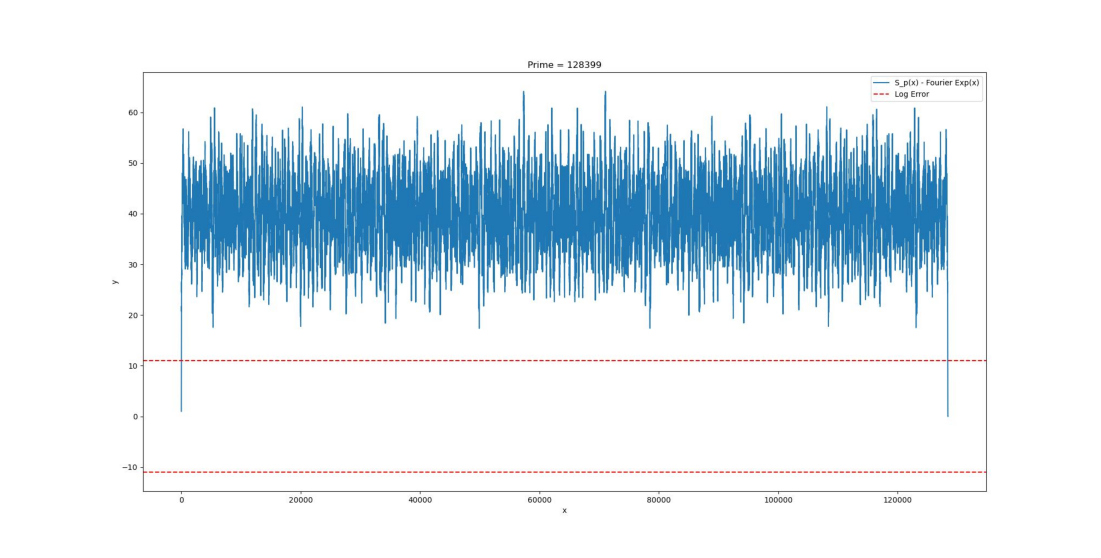

In [22]:
plot('error plots', [(128399)])

In [23]:
error_max = {prime : max(max(lst), -1 * min(lst)) for prime, lst in error_data.items()}

In [24]:
large_primes = [prime for prime, max in error_max.items() if max >= 70 and prime < 250000]
large_primes


[183119]

In [25]:
primes = []
char_maxs = []
fourier_maxs = []
error_maxs = []

for prime in error_data:
    try:
        error_lst    = error_data[prime]
        fourier_lst  = fourier_data[prime]
        char_sum_lst = char_sum_data[prime]
        max_mag      = error_max[prime]
        char_sum_max = max(max(char_sum_lst), -1 * min(char_sum_lst))
        fourier_max  = max(max(fourier_lst), -1 * min(fourier_lst))

        primes.append(prime)
        char_maxs.append(char_sum_max)
        fourier_maxs.append(fourier_max)
        error_maxs.append(max_mag)
    except:
        pass

df_max = pd.DataFrame({"prime" : primes, "error max" : error_maxs, "fourier maxs" : fourier_maxs, "char maxs" : char_maxs})

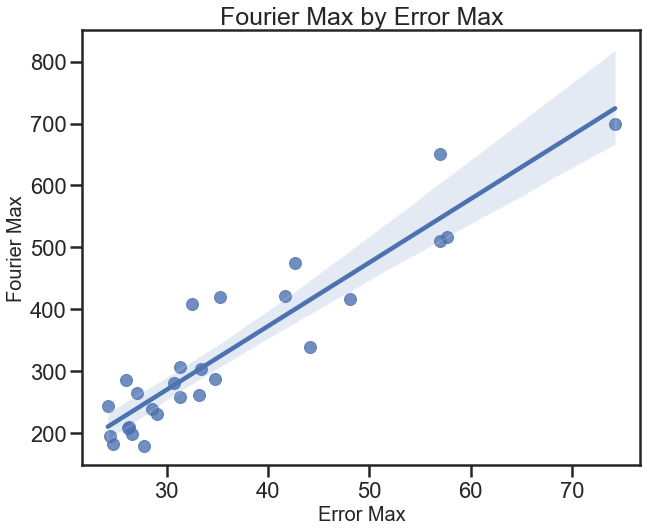

<AxesSubplot:title={'center':'Fourier Max by Error Max'}, xlabel='Error Max', ylabel='Fourier Max'>

In [26]:
scatter(error_maxs, fourier_maxs, "Error Max", "Fourier Max")

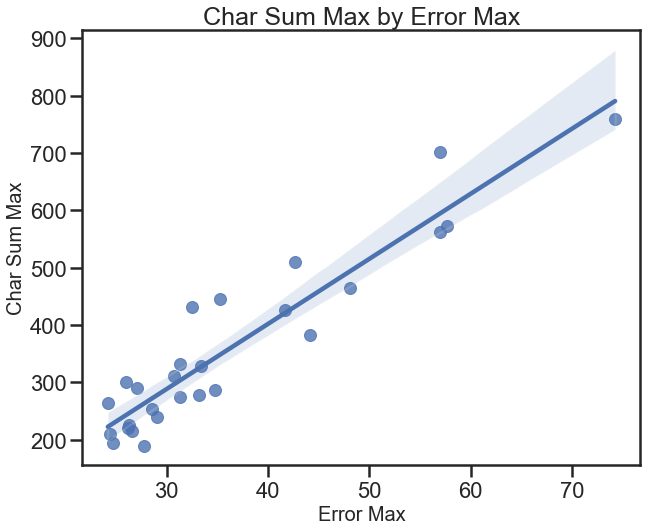

<AxesSubplot:title={'center':'Char Sum Max by Error Max'}, xlabel='Error Max', ylabel='Char Sum Max'>

In [33]:
scatter(error_maxs, char_maxs, "Error Max", "Char Sum Max")

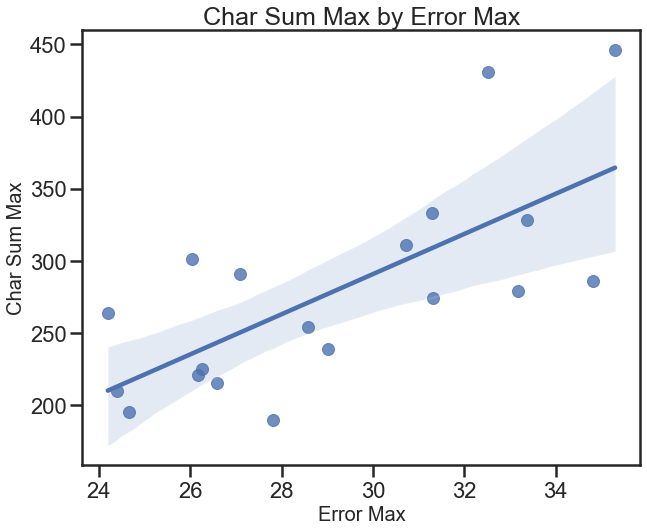

<AxesSubplot:title={'center':'Char Sum Max by Error Max'}, xlabel='Error Max', ylabel='Char Sum Max'>

In [34]:
small_errors = []
small_chars = []

for error, char in zip(error_maxs, char_maxs):
    if error <= 40:
        small_errors.append(error)
        small_chars.append(char)

scatter(small_errors, small_chars, "Error Max", "Char Sum Max")

In [35]:
df = create_df(196993)
sd_error   = np.std(error_lst)
mean_error = np.mean(error_lst)

def error_zscore(val):
    return round((val - mean_error) / sd_error, 3)

sd_fourier   = np.std(fourier_lst)
mean_fourier = np.mean(fourier_lst)

def fourier_zscore(val):
    return round((val - mean_fourier) / sd_fourier,3)

sd_char   = np.std(char_sum_lst)
mean_char = np.mean(char_sum_lst)

def char_zscore(val):
    return round((val - mean_char) / sd_char, 3)

df['error z score'] =  df["error"].apply(lambda val: error_zscore(val))
df['fourier z score'] =  df["fourier"].apply(lambda val: fourier_zscore(val))
df['char z score'] =  df["char"].apply(lambda val: char_zscore(val))
df.head()

,error,char,fourier,error z score,fourier z score,char z score
0,0.000000,0.0,0.000000,0.018,-0.577,-0.574
1,0.936914,1.0,0.063086,0.158,-0.577,-0.564
2,1.873828,2.0,0.126172,0.299,-0.576,-0.553
3,2.810742,3.0,0.189258,0.439,-0.575,-0.542
4,3.747657,4.0,0.252343,0.579,-0.575,-0.531


In [36]:
df['x'] = list(range(196993))

In [37]:
df["rel pos"] = df['x'].apply(lambda x : x / 196993 * 100)
df

,error,char,fourier,error z score,fourier z score,char z score,x,rel pos
0,0.000000,0.0,0.000000,0.018,-0.577,-0.574,0,0.000000
1,0.936914,1.0,0.063086,0.158,-0.577,-0.564,1,0.000508
2,1.873828,2.0,0.126172,0.299,-0.576,-0.553,2,0.001015
3,2.810742,3.0,0.189258,0.439,-0.575,-0.542,3,0.001523
4,3.747657,4.0,0.252343,0.579,-0.575,-0.531,4,0.002031
...,...,...,...,...,...,...,...,...
196988,-3.684571,-4.0,-0.315429,-0.534,-0.581,-0.618,196988,99.997462
196989,-2.747657,-3.0,-0.252343,-0.394,-0.580,-0.607,196989,99.997969
196990,-1.810742,-2.0,-0.189258,-0.253,-0.579,-0.596,196990,99.998477
196991,-0.873828,-1.0,-0.126172,-0.113,-0.579,-0.585,196991,99.998985


In [38]:
df[df["error z score"] >= 4.75]

,error,char,fourier,error z score,fourier z score,char z score,x,rel pos
20173,31.756953,231.0,199.243047,4.776,1.587,1.929,20173,10.240465
34282,31.747961,244.0,212.252039,4.775,1.729,2.070,34282,17.402649
72388,31.591923,138.0,106.408077,4.752,0.579,0.921,72388,36.746483
72409,32.226773,139.0,106.773227,4.847,0.583,0.932,72409,36.757144
72411,32.190313,139.0,106.809687,4.841,0.583,0.932,72411,36.758159
72412,33.171971,140.0,106.828029,4.988,0.583,0.943,72412,36.758667
72413,32.153554,139.0,106.846446,4.836,0.584,0.932,72413,36.759174
72415,32.116496,139.0,106.883504,4.830,0.584,0.932,72415,36.760189


None of fourier/char z scores are high

In [61]:
df[df["char z score"] >= 2.45]

,error,char,fourier,error z score,fourier z score,char z score,x,rel pos
25575,18.559910,279.0,260.440090,2.799,2.252,2.45,25575,12.982695
25581,18.602751,279.0,260.397249,2.805,2.252,2.45,25581,12.985741


<AxesSubplot:>

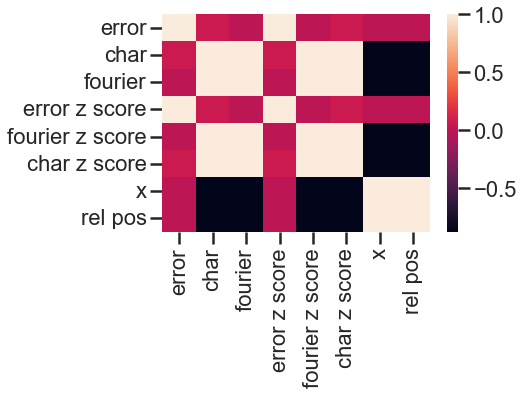

In [49]:
sns.heatmap(df.corr())

Looks like this trend of relationship only applies to max? There's no real correlation between the z scores pairwise

In [40]:
df.sort_values("error")

,error,char,fourier,error z score,fourier z score,char z score,x,rel pos
124580,-33.153554,-140.0,-106.846446,-4.950,-1.738,-2.092,124580,63.240826
124583,-32.208580,-139.0,-106.791420,-4.808,-1.737,-2.081,124583,63.242349
124581,-32.171971,-139.0,-106.828029,-4.803,-1.738,-2.081,124581,63.241333
124579,-32.135063,-139.0,-106.864937,-4.797,-1.738,-2.081,124579,63.240318
124577,-32.097854,-139.0,-106.902146,-4.792,-1.739,-2.081,124577,63.239303
...,...,...,...,...,...,...,...,...
72415,32.116496,139.0,106.883504,4.830,0.584,0.932,72415,36.760189
72413,32.153554,139.0,106.846446,4.836,0.584,0.932,72413,36.759174
72411,32.190313,139.0,106.809687,4.841,0.583,0.932,72411,36.758159
72409,32.226773,139.0,106.773227,4.847,0.583,0.932,72409,36.757144


Ok, there might have been some correlation between max magnitude of error, but it's not 100% since max error is not the same as outliers in fourier or char

In [41]:
df[(df['error z score'] > 4.7)]

,error,char,fourier,error z score,fourier z score,char z score,x,rel pos
20173,31.756953,231.0,199.243047,4.776,1.587,1.929,20173,10.240465
34282,31.747961,244.0,212.252039,4.775,1.729,2.070,34282,17.402649
72388,31.591923,138.0,106.408077,4.752,0.579,0.921,72388,36.746483
72396,31.456582,138.0,106.543418,4.731,0.580,0.921,72396,36.750544
72400,31.387186,138.0,106.612814,4.721,0.581,0.921,72400,36.752575
72402,31.352053,138.0,106.647947,4.716,0.581,0.921,72402,36.753590
72404,31.316627,138.0,106.683373,4.710,0.582,0.921,72404,36.754605
72409,32.226773,139.0,106.773227,4.847,0.583,0.932,72409,36.757144
72411,32.190313,139.0,106.809687,4.841,0.583,0.932,72411,36.758159
72412,33.171971,140.0,106.828029,4.988,0.583,0.943,72412,36.758667


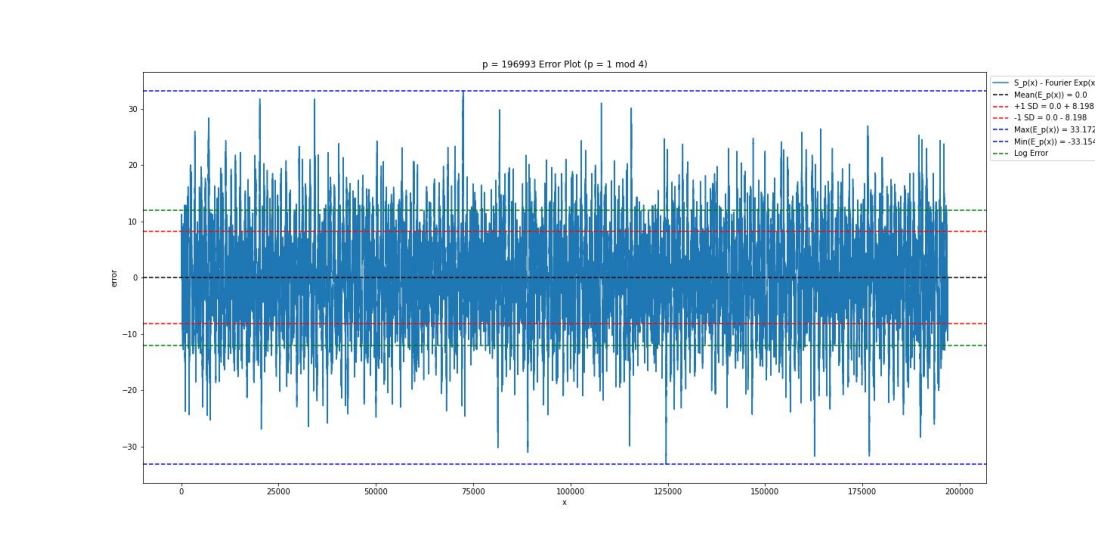

In [42]:
plot('error plots', [(196993)])

In [62]:
results

{141269: (1, 1.6095086356046412e-18, 7.137085374598465),
 113149: (1, -6.731847499622863e-17, 6.504170150559251),
 122021: (1, -5.590193707064326e-18, 6.705048406836319),
 117709: (1, -5.7949776680601835e-18, 6.609606331706121),
 125693: (1, -1.3069739803150148e-16, 6.805187094673613),
 129749: (1, -1.577170597838202e-17, 6.889123804578599),
 195457: (1, -1.3494193787592627e-16, 8.165777026654704),
 117673: (1, -3.0916002881644155e-17, 6.608585485649126),
 192529: (1, -5.904920179381601e-17, 8.104383904250582),
 196993: (1, 6.290510480908533e-17, 8.197799400419314),
 1020389: (1, 6.996874142035524e-17, 16.429832141712446),
 108529: (1, 2.514059933583452e-17, 6.393638389749282),
 178757: (1, -3.0527298011476863e-17, 7.862270063977891),
 150929: (1, 4.218183988769884e-17, 7.325114547334611),
 997: (1, 1.7817019452359583e-18, 1.0387686561322924),
 108013: (1, -4.8416343728943156e-17, 6.378421343890369),
 116257: (1, 1.8579955759315177e-17, 6.568698786339742),
 197: (1, 3.381389922716213e-